# Playing with stock trading
## Author: Hoang Van Phan

In this notebook, I attempt to develop a simple trading strategy that only relies on the trend of a stock's daily open price.

In [103]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf # for downloading stock price from Yahoo Finance
import scipy.signal as signal
from datetime import datetime

# Save a list of nice looking colors
my_colors = plt.get_cmap('tab10')

## Import a stock price history

Amazon's stock price is used for testing. I will only look at stock price after 2010.

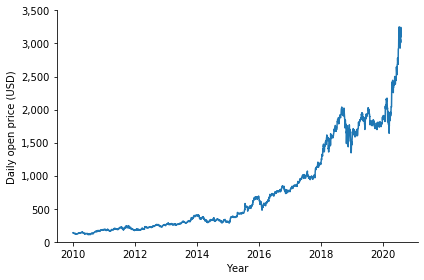

In [62]:
# Pick Amazon's stock
amzn = yf.Ticker("AMZN")
amzn_price = amzn.history(start="2010-01-01")

# Plot
fig, ax = plt.subplots(tight_layout=True)
ax.plot(amzn_price["Open"])
ax.set_xlabel("Year")
ax.set_ylabel("Daily open price (USD)")
ax.set_ylim(0,3500)
temp = ax.get_yticks()
ax.set_yticks(temp)
ax.set_yticklabels([f"{s:,.0f}" for s in temp])
ax.set_title("Amazon stock (AMZN)")
sns.despine(fig=fig)

## Trading strategy 1 implementation

Trading strategy 1 is simple: if stock price of a company has risen for x days (excluding weekends) consecutively after a local minimum, buy **one** share, and if stock price has fallen for x days consecutively after a local maximum, sell **all** shares.

First, I implement the trading strategy as function trading_start1(). The function will return the date and action of all taken transactions.

In [298]:
def trading_strat1(price, min_x=1, max_x=5, fees=0, budget=None):
    '''
    This function will implement a simple version of the trading strategy where number of days of rising stock is equal to the
    number of days of falling stock.
    
    Input:
    ----------
    price: numpy array
        An 1D numpy array containing the daily stock price.
    min_x: int
        The minimum number of days to test the trading strategy.
        Default is 1.
    max_x: int
        The maximum number of days to test the trading strategy.
        Default is 5.
    fees: float
        The brokerage fees per transaction.
        Default is 0.
    budget: int or None
        The budget of the trader. If int, then the trade can only buy stocks if he has enough money left. If None, assume
        the trader has infinite amount of money.
        Default is None.
        
    Output:
    ----------
    A dictionary of transaction history
    The keys indicate value of x.
    The values are numpy arrays of shape (number of transactions, 2)
    First column is the index of price array at which a transaction occurs
    Second column indicates whether the transaction is buying (denoted by +1, ie buying one share) or selling (denoted by -n,
    ie, selling all n shares)
    '''
    
    if budget is None:
        budget = np.inf
    
    out_dict = {}
    
    # Find indices of all local minima and maxima
    minima = signal.argrelmin(price)[0]
    maxima = signal.argrelmax(price)[0]
    
    # Combine the indices and sort
    # The local minima and maxima will be alternating
    combine = np.sort(np.hstack([minima, maxima]))
    
    # Find the gap between a pair of adjacent minimum and maximum
    combine_gap = np.diff(combine)
    
    # Convert the minima and maxima arrays into sets for faster 'in' operator later on
    minima = set(minima)
    maxima = set(maxima)
    
    # Loop through each value of x to be tested
    for x in range(min_x, max_x+1):
        temp_budget = budget # reset the current budget
        n_shares = 0 # track the number of shares currently own
        trade_index = [] # track the index when transaction occurs
        trade_info = [] # track the number of shares bought or sold
        
        # Go through gaps that are at least x-days long
        for i in combine[np.where(combine_gap >= x)]:                
            # Buy if have enough money left  
            if (i in minima) and (temp_budget >= price[i+x] - fees):
                temp_budget = temp_budget - price[i+x] - fees
                trade_index.append(i+x)
                trade_info.append(1)
                n_shares += 1
                
            # Sell
            elif (i in maxima) and (n_shares > 0):
                temp_budget = temp_budget + price[i+x]*n_shares - fees
                trade_index.append(i+x)
                trade_info.append(-n_shares)
                n_shares = 0

        # Update dictionary
        out_dict[x] = np.array([trade_index, trade_info]).T
        
    return out_dict

Let us visualize the transaction history for x = 3 days, when I have an unlimited budget (ie, I can buy as many shares as I want without budget constraint).

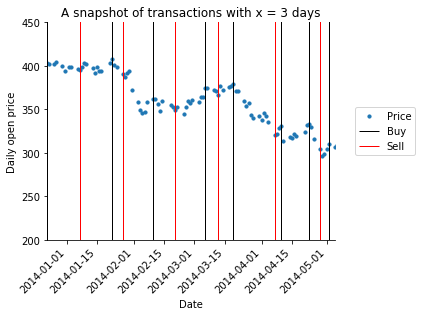

In [281]:
# Convert stock price and date to numpy arrays
amzn_price_np = amzn_price["Open"].to_numpy()
amzn_date = amzn_price.index.to_numpy()

# Implement trading strategy
out_dict = trading_strat1(amzn_price_np, min_x=3)

# Visualize trading patterns to confirm trading_simple() works as expected
fig, ax = plt.subplots(figsize=(6,4.5), tight_layout=True)
ax.scatter(amzn_date, amzn_price_np, s=10, label="Price")
ax.vlines(amzn_date[out_dict[3][out_dict[3][:,1]>0,0]], 0, 4000, lw=1, label="Buy")
ax.vlines(amzn_date[out_dict[3][out_dict[3][:,1]<0,0]], 0, 4000, lw=1, color='red', label="Sell")
ax.set_xlim(amzn_date[1000],amzn_date[1090])
ax.set_ylim(200,450)
ax.set_xticklabels([datetime.fromordinal(int(s)).date() for s in ax.get_xticks()], rotation=45, ha='right')
ax.set_xlabel("Date")
ax.set_ylabel("Daily open price")
ax.legend(bbox_to_anchor=(1.05,0.5), loc="center left")
ax.set_title("A snapshot of transactions with x = 3 days")
sns.despine(fig=fig)

Now, to check how effective the trading strategy is, I will look at three numbers:
* Earning: how much money I earn from selling shares, minus how much money I spend on buying shares.
* Share worth: how much the shares I still own at the end of the period are worth.
* Profit: equal earning plus share worth, ie, how much I earn if I sell all the shares I still own.

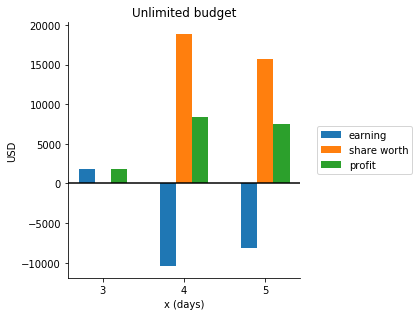

In [284]:
bar_width = 0.2
fig, ax = plt.subplots(figsize=(6,4.5), tight_layout=True)
for key, value in out_dict.items():
    # Plot earning
    earning = -np.sum(amzn_price_np[value[:,0]]*value[:,1])
    bar1 = ax.bar(key-bar_width, earning, width=bar_width, color=my_colors(0))
    
    # Plot share worth
    share_worth = np.sum(value[:,1])*amzn_price_np[-1]
    bar2 = ax.bar(key, share_worth, width=bar_width, color=my_colors(1))
    
    # Plot profit
    bar3 = ax.bar(key+bar_width, earning+share_worth, width=bar_width, color=my_colors(2))
ax.axhline(0,color='black')
ax.set_xticks(list(out_dict.keys()))
ax.set_xlabel("x (days)")
ax.set_ylabel("USD")
ax.set_title("Unlimited budget")
ax.legend([bar1, bar2, bar3], ["earning","share worth","profit"], bbox_to_anchor=(1.05,0.5), loc="center left")
sns.despine(fig=fig)

It is suspicious that the profit changes so much between x = 3 and 4 days. Let us look at the trading activities during the last 120 days.

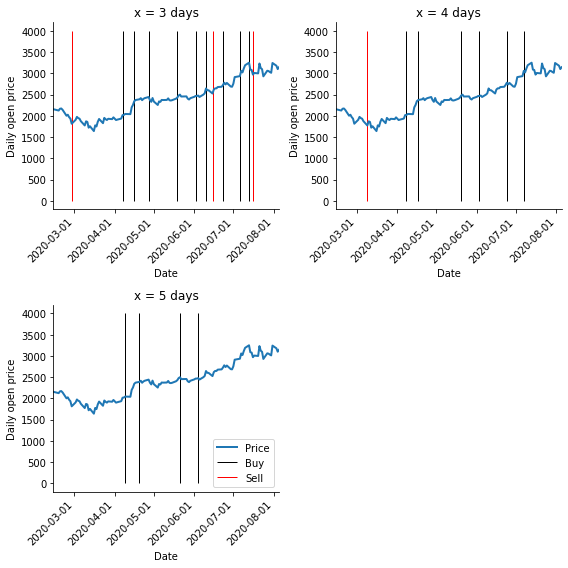

In [329]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8), tight_layout=True)
for counter, key in enumerate(out_dict.keys()):
    irow = int(counter/2)
    icol = int(counter % 2)
    ax[irow, icol].plot(amzn_date, amzn_price_np, lw=2, label="Price")
    ax[irow, icol].vlines(amzn_date[out_dict[key][out_dict[key][:,1]>0,0]], 0, 4000, lw=1, label="Buy")
    ax[irow, icol].vlines(amzn_date[out_dict[key][out_dict[key][:,1]<0,0]], 0, 4000, lw=1, color='red', label="Sell")
    ax[irow, icol].set_title(f"x = {key} days")
    ax[irow, icol].set_xlim(amzn_date[-120],amzn_date[-1])
    ax[irow, icol].set_xticklabels([datetime.fromordinal(int(s)).date() for s in ax[irow, icol].get_xticks()],
                                   rotation=45, ha='right')
    ax[irow, icol].set_xlabel("Date")
    ax[irow, icol].set_ylabel("Daily open price")
ax[1,0].legend(loc="lower right")
fig.delaxes(ax[1,1])
sns.despine(fig=fig)

It seems that the profit of x = 3 days is low because the stock price is too volatile for a 3-day window, so that sometimes the share price is sold too fast, missing out on higher profit. One the other hands, because AMZN stock price at the moment is very high, the share worth of x = 4 and 5 days is so high that the profit becomes much higher than that of x = 3 days.

Let us now impose a budget of $10,000 and test the strategy again.

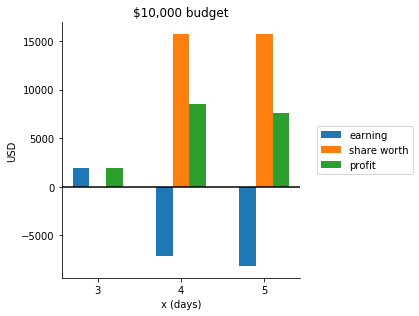

In [299]:
# Check for x = 3, 4, 5 days with a $10,000 budget
out_dict_10k = trading_strat1(amzn_price_np, min_x=3, max_x=5, budget=10_000)

bar_width = 0.2
fig, ax = plt.subplots(figsize=(6,4.5), tight_layout=True)
for key, value in out_dict_10k.items():
    # Plot earning
    earning = -np.sum(amzn_price_np[value[:,0]]*value[:,1])
    bar1 = ax.bar(key-bar_width, earning, width=bar_width, color=my_colors(0))
    
    # Plot share worth
    share_worth = np.sum(value[:,1])*amzn_price_np[-1]
    bar2 = ax.bar(key, share_worth, width=bar_width, color=my_colors(1))
    
    # Plot profit
    bar3 = ax.bar(key+bar_width, earning+share_worth, width=bar_width, color=my_colors(2))
ax.axhline(0,color='black')
ax.set_xticks(list(out_dict.keys()))
ax.set_xlabel("x (days)")
ax.set_ylabel("USD")
ax.set_title("$10,000 budget")
ax.legend([bar1, bar2, bar3], ["earning","share worth","profit"], bbox_to_anchor=(1.05,0.5), loc="center left")
sns.despine(fig=fig)

The profits when imposed a budget are very similar to when having an infinite budget.

The return on investment (ROI) is not very high with this trading strategy.

In [303]:
# Calculate ROI per year (without taking into account time value of money)
# calculate number of years, assuming 365 days/year
n_years = float(amzn_date[-1] - amzn_date[0])/1e9/60/60/24/365
for key, value in out_dict_10k.items():
    earning = -np.sum(amzn_price_np[value[:,0]]*value[:,1])
    share_worth = np.sum(value[:,1])*amzn_price_np[-1]
    profit = earning + share_worth
    print(f"Annual ROI for x = {key} days: {profit/10000/n_years*100:.2f}%")

Annual ROI for x = 3 days: 1.79%
Annual ROI for x = 4 days: 8.08%
Annual ROI for x = 5 days: 7.13%


I will now look for places that can be improved. Firstly, can the budget be used more efficiently? Should I buy more than 1 shares when there's a consecutive increase?

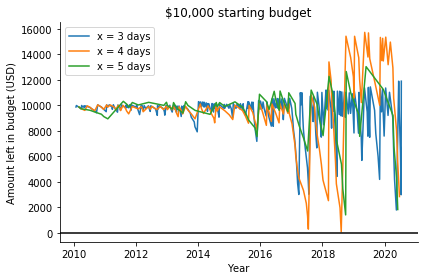

In [304]:
fig, ax = plt.subplots(tight_layout=True)
for key, value in out_dict_10k.items():
    ax.plot(amzn_date[value[:,0]], 10000-np.cumsum(amzn_price_np[value[:,0]]*value[:,1]), label=f"x = {key} days")
ax.axhline(0, color="black")
ax.set_xlabel("Year")
ax.set_ylabel("Amount left in budget (USD)")
ax.set_title("$10,000 starting budget")
ax.legend(loc="upper left")
sns.despine(fig=fig)

Before 2017, the budget was not fully utilized because the stock price was low, and the strategy never buys more than 1 share at a time. Therefore, the number of shares to buy at any given time should depend on how much money the budgest still has left.

Next, can be the buy/sell decision be improved? Let's look at the transactions of x = 4 days (because it has the highest ROI).

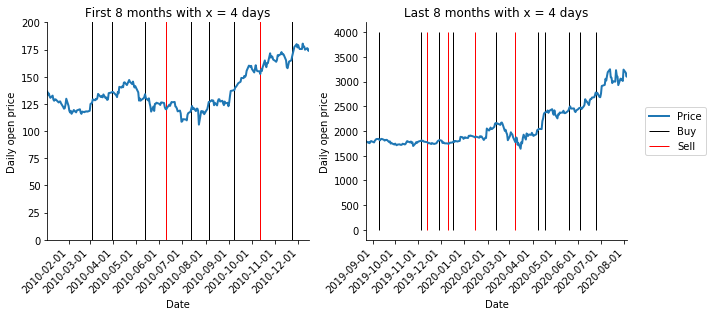

In [328]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4.5), tight_layout=True)
# All transactions
ax[0].plot(amzn_date, amzn_price_np, lw=2, label="Price")
ax[0].vlines(amzn_date[out_dict_10k[4][out_dict_10k[4][:,1]>0,0]], 0, 4000, lw=1, label="Buy")
ax[0].vlines(amzn_date[out_dict_10k[4][out_dict_10k[4][:,1]<0,0]], 0, 4000, lw=1, color='red', label="Sell")
ax[0].set_xlim(amzn_date[0],amzn_date[240])
ax[0].set_ylim(0,200)
ax[0].set_xticklabels([datetime.fromordinal(int(s)).date() for s in ax[0].get_xticks()], rotation=45, ha='right')
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Daily open price")
ax[0].set_title("First 8 months with x = 4 days")

# Last 120 days
ax[1].plot(amzn_date, amzn_price_np, lw=2, label="Price")
ax[1].vlines(amzn_date[out_dict_10k[4][out_dict_10k[4][:,1]>0,0]], 0, 4000, lw=1, label="Buy")
ax[1].vlines(amzn_date[out_dict_10k[4][out_dict_10k[4][:,1]<0,0]], 0, 4000, lw=1, color='red', label="Sell")
ax[1].set_xlim(amzn_date[-240],amzn_date[-1])
ax[1].set_xticklabels([datetime.fromordinal(int(s)).date() for s in ax[1].get_xticks()], rotation=45, ha='right')
ax[1].legend(bbox_to_anchor=(1.05,0.5), loc="center left")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Daily open price")
ax[1].set_title("Last 8 months with x = 4 days")
sns.despine(fig=fig)

It is obvious that sometimes shares are sold at a price lower than it was most recently bought. Therefore, the sell decision should also take into account the price of bought shares.